In [1]:
import tensorflow as tf 
import numpy as np 
from tensorflow import keras 
import os 
import math 
import random 
import pickle 
import glob
import matplotlib.pyplot as plt 
from collections import deque 
from tensorflow.keras import layers
import time 
import scipy.io as sio

from vehicle_model_DDPG2 import Environment 
from cell_model import CellModel 
from driver_MDP import Driver_MDP 

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
drving_cycle = '../../OC_SIM_DB/OC_SIM_DB_Cycles/Highway/01_FTP72_fuds.mat'
battery_path = "../../OC_SIM_DB/OC_SIM_DB_Bat/OC_SIM_DB_Bat_pb_91_150.mat"
motor_path = "../../OC_SIM_DB/OC_SIM_DB_Mot/OC_SIM_DB_Mot_pm_95_145_X2.mat"
cell_model = CellModel()
# env = Environment(cell_model, drving_cycle, battery_path, motor_path, 10)
driver = Driver_MDP(0.02)

num_states = 4

In [3]:
class OUActionNoise: 
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None): 
        self.theta = theta 
        self.mean = mean 
        self.std_dev = std_deviation 
        self.dt = dt 
        self.x_initial = x_initial 
        self.reset() 
        
    def reset(self): 
        if self.x_initial is not None: 
            self.x_prev = self.x_initial 
        else: 
            self.x_prev = 0 
            
    def __call__(self): 
        x = (
             self.x_prev + self.theta * (self.mean - self.x_prev) * self.dt 
            + self.std_dev * np.sqrt(self.dt) * np.random.normal() 
        )
        self.x_prev = x 
        return x 

In [4]:
class Buffer: 
    def __init__(self, buffer_capacity=100000, batch_size=64):      
        self.buffer_capacity = buffer_capacity 
        self.batch_size = batch_size 
        self.buffer_counter = 0 
        
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, 1))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))
        
    def record(self, obs_tuple):
        index = self.buffer_counter % self.buffer_capacity 

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]
        
        self.buffer_counter += 1 
        
    def learn(self): 
        record_range = min(self.buffer_counter, self.buffer_capacity)
        batch_indices = np.random.choice(record_range, self.batch_size)

        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])
        
        with tf.GradientTape() as tape: 
            target_actions = target_actor(next_state_batch)
            y = reward_batch + gamma * target_critic([next_state_batch, target_actions])
            critic_value = critic_model([state_batch, action_batch])
            critic_loss = tf.math.reduce_mean(tf.square(y - critic_value)) 
        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables) 
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )
        
        with tf.GradientTape() as tape: 
            actions = actor_model(state_batch)
            critic_value = critic_model([state_batch, actions])
            actor_loss = - tf.math.reduce_mean(critic_value)
        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables) 
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )
        

In [5]:
def update_target(tau): 
    new_weights = [] 
    target_variables = target_critic.weights
    for i, variable in enumerate(critic_model.weights): 
        new_weights.append(target_variables[i] * (1 - tau) + tau * variable)
    target_critic.set_weights(new_weights)
    
    new_weights = [] 
    target_variables = target_actor.weights
    for i, variable in enumerate(actor_model.weights): 
        new_weights.append(target_variables[i] * (1 - tau) + tau * variable)
    target_actor.set_weights(new_weights)
    

In [6]:
def get_actor(): 
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
    
    inputs = layers.Input(shape=(num_states))
    inputs_batchnorm = layers.BatchNormalization()(inputs)
    
    out = layers.Dense(512, activation="relu")(inputs_batchnorm)
#     out = layers.BatchNormalization()(out)
    out = layers.Dense(512, activation="relu")(out)
#     out = layers.BatchNormalization()(out)
    outputs = layers.Dense(1, activation="sigmoid", 
                          kernel_initializer=last_init)(out)
    model = tf.keras.Model(inputs, outputs)
    return model

In [7]:
def get_critic(): 
    state_input = layers.Input(shape=(num_states))
    state_input_batchnorm = layers.BatchNormalization()(state_input)
    
    state_out = layers.Dense(16, activation="relu")(state_input_batchnorm)
#     state_out = layers.BatchNormalization()(state_out)
    state_out = layers.Dense(32, activation="relu")(state_out)
#     state_out = layers.BatchNormalization()(state_out)
    
    action_input = layers.Input(shape=(1))
    action_out = layers.Dense(32, activation="relu")(action_input)
#     action_out = layers.BatchNormalization()(action_out)
    
    concat = layers.Concatenate()([state_out, action_out]) 
    
    out = layers.Dense(512, activation="relu")(concat)
#     out = layers.BatchNormalization()(out)
    out = layers.Dense(512, activation="relu")(out)
#     out = layers.BatchNormalization()(out)
    outputs = layers.Dense(1)(out)
    
    model = tf.keras.Model([state_input, action_input], outputs)
    return model 
    

In [8]:
def policy(state, noise_object): 
    j_min = state[0][2].numpy()
    j_max = state[0][3].numpy()
    sampled_action = tf.squeeze(actor_model(state)) 
    noise = noise_object()
    sampled_action = sampled_action.numpy() + noise 
    legal_action = sampled_action * j_max 
    legal_action = np.clip(legal_action, j_min, j_max)
#     print(j_min, j_max, legal_action, noise)
    return legal_action 
    

In [9]:
def policy_epsilon_greedy(state, eps): 
    j_min = state[0][-2].numpy()
    j_max = state[0][-1].numpy()

    if random.random() < eps: 
        a = random.randint(0, 9)
        return np.linspace(j_min, j_max, 10)[a]
    else: 
        sampled_action = tf.squeeze(actor_model(state)).numpy()  
        legal_action = sampled_action * j_max 
        legal_action = np.clip(legal_action, j_min, j_max)
        return legal_action

In [10]:
std_dev = 0.2 
ou_noise = OUActionNoise(mean=0, std_deviation=0.2)

critic_lr = 0.0005 
actor_lr = 0.00025 
critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

total_episodes = 100
gamma = 0.95 
tau = 0.001 

MAX_EPSILON = 1.0
MIN_EPSILON = 0.01 
DECAY_RATE = 0.00005
BATCH_SIZE = 32 
DELAY_TRAINING = 1000 

In [11]:
def initialization(): 
    actor_model = get_actor() 
    critic_model = get_critic() 
    target_actor = get_actor() 
    target_critic = get_critic() 
    target_actor.set_weights(actor_model.get_weights())
    target_critic.set_weights(critic_model.get_weights())

    buffer = Buffer(500000, BATCH_SIZE)
    return actor_model, critic_model, target_actor, target_critic, buffer

In [12]:
def save_weights(actor_model, critic_model, target_actor, target_critic, root): 
    actor_model.save_weights("./{}/actor_model_checkpoint".format(root))
    critic_model.save_weights("./{}/critic_model_checkpoint".format(root))
    target_actor.save_weights("./{}/target_actor_checkpoint".format(root))
    target_critic.save_weights("./{}/target_critic_checkpoint".format(root))
    print("model is saved..")

In [13]:
def initialization_env(driving_path, reward_factor):
    env = Environment(cell_model, driving_path, battery_path, motor_path, reward_factor)
    return env 

In [14]:
def test_agent(actor_model, reward_factor):
    test_cycle = driver.get_cycle() 
    env = initialization_env(test_cycle, reward_factor)
    
    total_reward = 0
    state = env.reset() 
    while True: 
        tf_state = tf.expand_dims(tf.convert_to_tensor(state), 0)
        action = policy_epsilon_greedy(tf_state, -1)
        next_state, reward, done = env.step(action)
        
        state = next_state 
        total_reward += reward 
        
        if done: 
            break 
        
    SOC_deviation_history = np.sum(np.abs(np.array(env.history["SOC"]) - 0.6)) 
    
    print("******************* Test is start *****************")
#     print(test_cycle)
    print('Total reward: {}'.format(total_reward), 
          "SOC: {:.4f}".format(env.SOC), 
          "Cumulative_SOC_deviation: {:.4f}".format(SOC_deviation_history), 
          "Fuel Consumption: {:.4f}".format(env.fuel_consumption))
    print("******************* Test is done *****************")
    print("")
    plt.plot(test_cycle)
    plt.show() 
    return env.history  
    


Trial 0

../data/driving_cycles/city\01_FTP72_fuds.mat

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocas

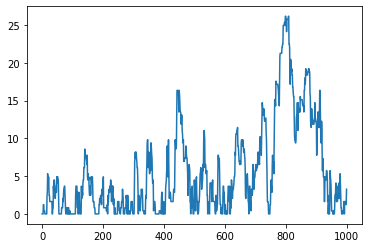

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 81.307
Episode: 11 Exploration P: 0.4991 Total reward: -3791.661879146816 SOC: 1.0000 Cumulative_SOC_deviation: 317.9139 Fuel Consumption: 612.5228

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 72.834
Episode: 12 Exploration P: 0.4667 Total reward: -3354.697427369145 SOC: 1.0000 Cumulative_SOC_deviation: 281.1821 Fuel Consumption: 542.8765

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 73.327
Episode: 13 Exploration P: 0.4364 Total reward: -3385.783067941934 SOC: 1.0000 Cumulative_SOC_deviation: 283.1057 Fuel Consumption: 554.7260

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 71.779
Episode: 14 Exploration P: 0.4081 Total reward: -3150.020569560212 SOC: 0.9799 Cumulative_SOC_deviation: 264.4327 Fuel Consumption: 505.6937

../data/

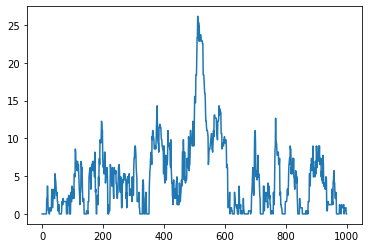

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 75.641
Episode: 21 Exploration P: 0.2562 Total reward: -1639.2153494862514 SOC: 0.8141 Cumulative_SOC_deviation: 132.8139 Fuel Consumption: 311.0764

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 78.592
Episode: 22 Exploration P: 0.2399 Total reward: -1593.6845433059157 SOC: 0.7987 Cumulative_SOC_deviation: 130.0444 Fuel Consumption: 293.2409

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 77.855
Episode: 23 Exploration P: 0.2246 Total reward: -1517.6242439153393 SOC: 0.7856 Cumulative_SOC_deviation: 124.0012 Fuel Consumption: 277.6119

../data/driving_cycles/city\01_FTP72_fuds.mat
maximum steps, simulation is done ... 
elapsed_time: 76.771
Episode: 24 Exploration P: 0.2104 Total reward: -1695.147301409922 SOC: 0.8023 Cumulative_SOC_deviation: 139.7677 Fuel Consumption: 297.4700

../da

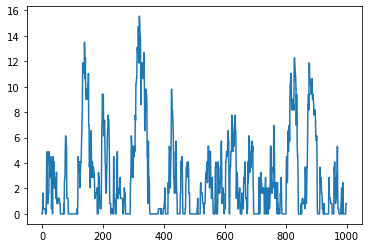

../data/driving_cycles/city\01_FTP72_fuds.mat


In [ ]:
# print(env.version)

num_trials = 1
results_dict = {} 
driving_cycle_paths = glob.glob("../data/driving_cycles/city/*.mat")[:1]

for trial in range(num_trials): 
    print("")
    print("Trial {}".format(trial))
    print("")
    
    actor_model, critic_model, target_actor, target_critic, buffer = initialization()
    
    eps = MAX_EPSILON 
    steps = 0
    
    episode_rewards = [] 
    episode_SOCs = [] 
    episode_FCs = [] 
    episode_test_history = [] 
    episode_num_test = [] 
    for ep in range(total_episodes): 
        driving_cycle_path = np.random.choice(driving_cycle_paths)
        print(driving_cycle_path)
        drv_cycle = sio.loadmat(driving_cycle_path)
        driving_cycle = drv_cycle["sch_cycle"][:, 1]
#         driving_cycle = driver.get_cycle() 
        env = initialization_env(driving_cycle, 10)
        
        start = time.time() 
        state = env.reset() 
        episodic_reward = 0 

        while True: 
            tf_state = tf.expand_dims(tf.convert_to_tensor(state), 0)
            action = policy_epsilon_greedy(tf_state, eps)
    #         print(action)
            next_state, reward, done = env.step(action)
            if done: 
                next_state = [0] * num_states 

            buffer.record((state, action, reward, next_state))
            episodic_reward += reward 

            if steps > DELAY_TRAINING: 
                buffer.learn() 
                update_target(tau)
                eps = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * np.exp(-DECAY_RATE * (steps
                                                                        -DELAY_TRAINING))

            steps += 1

            if done: 
                break 

            state = next_state 

        elapsed_time = time.time() - start 
        print("elapsed_time: {:.3f}".format(elapsed_time))
        episode_rewards.append(episodic_reward) 
        episode_SOCs.append(env.SOC)
        episode_FCs.append(env.fuel_consumption) 

    #     print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
        SOC_deviation_history = np.sum(np.abs(np.array(env.history["SOC"]) - 0.6)) 
        print(
              'Episode: {}'.format(ep + 1),
              "Exploration P: {:.4f}".format(eps),
              'Total reward: {}'.format(episodic_reward), 
              "SOC: {:.4f}".format(env.SOC), 
              "Cumulative_SOC_deviation: {:.4f}".format(SOC_deviation_history), 
              "Fuel Consumption: {:.4f}".format(env.fuel_consumption), 
        )
        print("")
        
        if (ep + 1) % 10 == 0: 
            history = test_agent(actor_model, 10)
            episode_test_history.append(history) 
            episode_num_test.append(ep + 1)
            
    root = "trained_model_on_FTP72".format(trial+1)
    save_weights(actor_model, critic_model, target_actor, target_critic, root)
    
    results_dict[trial + 1] = {
        "rewards": episode_rewards, 
        "SOCs": episode_SOCs, 
        "FCs": episode_FCs, 
        "test_history": episode_test_history, 
        "test_episode_num": episode_num_test, 
    }

In [ ]:
with open("DDPG1.pkl", "wb") as f: 
    pickle.dump(results_dict, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# results_dict